## MOM025 Atl PI Pos

In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage




Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [3]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.9.6


In [4]:
CntrlDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/'
PertDir = '/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/'
#DwnDir = '/g/data1/v45/pas561/mom/archive/wombat_jun16z_Dwn/'

ExpDirs=[CntrlDir, PertDir]
print ExpDirs

['/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/', '/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/']


In [5]:
#calc the wind energy anomaly and plot tau_x
Ocean_File = os.path.join(PertDir,'output501/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tau_x.shape

pert_tx=ff.tau_x.load()

#calc the wind energy anomaly and plot tau_x
Ocean_File = os.path.join(CntrlDir,'output501/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tau_x.shape

cntrl_tx=ff.tau_x.load()

/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/output501/ocean.nc
(1, 1080, 1440)
/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/output501/ocean.nc
(1, 1080, 1440)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/xarray/core/indexing.py:482: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  self.array[key] = value


(1080, 1440)
Area weighted anomaly 10E12 N:  0.16529152972


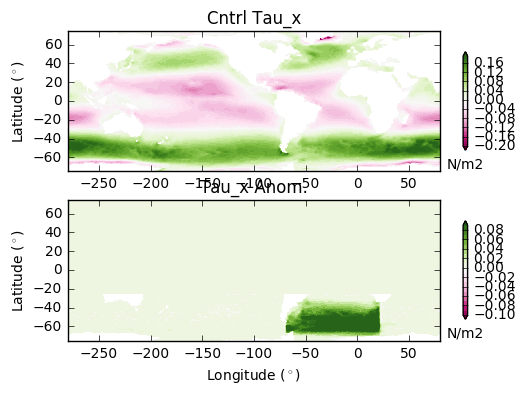

In [6]:
clev = np.arange(-.2,.2,.01)

plt.subplot(211)
plt.contourf(geolon_t,geolat_t,cntrl_tx[0],cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m2')
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-75,75])
tit='Cntrl Tau_x'
plt.title(tit)

clev = np.arange(-.1,.1,.01)

anom=pert_tx[0]-cntrl_tx[0]

#anom[np.where(anom<-.01)]=0
j1=np.argwhere(yt_ocean<-25)
j1=j1[-1]
anom[j1:,:]=0

net_anom=anom*area_t
print net_anom.shape
net_anom=np.sum(net_anom)/10E12
print 'Area weighted anomaly 10E12 N: ', np.array_str(net_anom,precision=1)

plt.subplot(212)
plt.contourf(geolon_t,geolat_t,anom,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('N/m2')
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-75,75])
tit='Tau_x Anom. (Net Anomaly (10^12 N)' + np.array_str(net_anom,precision=2) + ')'
tit='Tau_x Anom.'
plt.title(tit)

## Calc the GMOC from ty_trans_rho for forcing cases

In [7]:
Ocean_File = os.path.join(PertDir,'output*/ocean.nc')
print Ocean_File

ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

pert_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(PertDir,'pi_gmocs.npy')
a=np.save(of,pert_gmoc)

/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/output*/ocean.nc
(16, 80, 1080, 1440)
(16, 80, 1080)


In [60]:
#calc ape cntrl run 50 year time-series
#Ocean_File = os.path.join('/g/data1/v45/APE-MOM/gfdl_nyf_1080_cp','output5*/ocean.nc')
#print Ocean_File

#ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
#print ff.ty_trans_rho.shape

#cntrl_gmoc=ff.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

#print cntrl_gmoc.shape

#of=os.path.join('/g/data1/v45/pas561/mom/archive/','cntrl_gmocs.npy')
#a=np.save(of,cntrl_gmoc)

/g/data1/v45/APE-MOM/gfdl_nyf_1080_cp/output5*/ocean.nc
(51, 80, 1080, 1440)
(51, 80, 1080)


In [8]:
of=os.path.join(PertDir,'pi_gmocs.npy')
pert_gmoc=np.load(of)
print pert_gmoc.shape

of=os.path.join('/g/data1/v45/pas561/mom/archive/','cntrl_ape_gmocs.npy')
cntrl_gmoc=np.load(of)
print cntrl_gmoc.shape


(16, 80, 1080)
(51, 80, 1080)


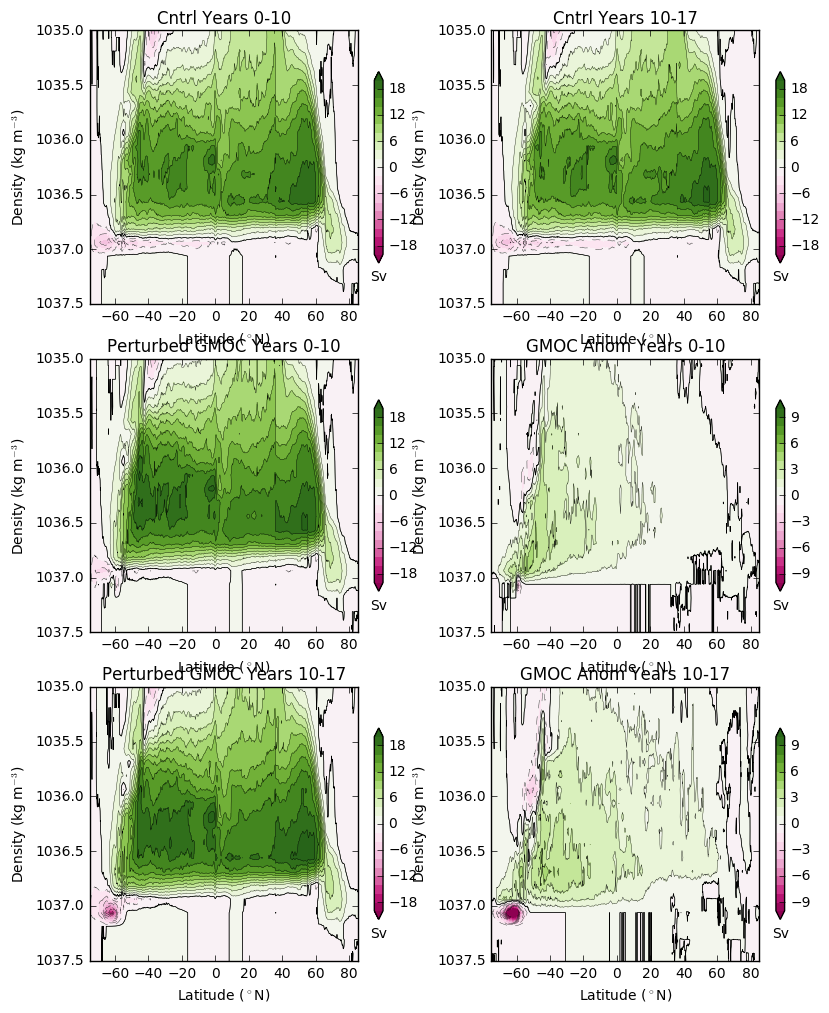

In [9]:
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=0
t2=10

plt.subplot(321)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=17

plt.subplot(322)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=0
t2=10

clev = np.arange(-20,22,2)

plt.subplot(323)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='Perturbed GMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(324)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='GMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=17

clev = np.arange(-20,22,2)

plt.subplot(325)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='Perturbed GMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(326)
plt.contourf(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_gmoc[t1:t2,:,:],axis=0)-np.mean(cntrl_gmoc[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
tit='GMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)




In [11]:
#plot time series of AABW
T=np.arange(17)
print T.shape

# do lower cell average between lats
j1=np.argwhere(yt_ocean<-65)# and lat<-45)
j2=np.argwhere(yt_ocean<-60)# and lat<-45)
j1=j1[-1]
j2=j2[-1]
#print yt_ocean[j1:j2]

z1=np.argwhere(potrho<1036.75)# and lat<-45)
z1=z1[-1]
#print potrho[z1:]

cntrl67_psj = cntrl_gmoc[:,z1:,j1:j2]
#print cntrl67_psj.shape
cntrl67_psj_bar = np.mean(cntrl67_psj,2)
#print cntrl67_psj_bar.shape
cntrl67_psj_ts = -np.min(cntrl67_psj_bar,1)
#print cntrl67_psj_ts.shape
#print cntrl67_psj_ts

pert67_psj = pert_gmoc[:,z1:,j1:j2]
#print pert67_psj.shape
pert67_psj_bar = np.mean(pert67_psj,2)
#print pert67_psj_bar.shape
pert67_psj_ts = -np.min(pert67_psj_bar,1)
pert67_psj_ts=np.insert(pert67_psj_ts,0,cntrl67_psj_ts[0])
#print pert67_psj_ts.shape
#print pert67_psj_ts



(17,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


(17,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: converting an array with ndim > 0 to an

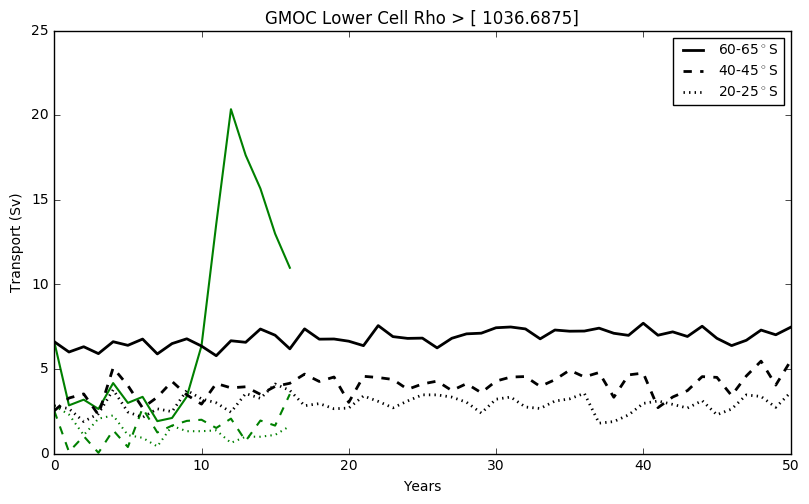

In [12]:
#plot time series of AABW
T=np.arange(17)
print T.shape

# do lower cell average between lats 60-65S
j1=np.argwhere(yt_ocean<-65)
j2=np.argwhere(yt_ocean<-60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(potrho<1036.75)
z1=z1[-1]

lc_cntrl60_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl60_psj_bar = np.mean(lc_cntrl60_psj,2)
lc_cntrl60_psj_ts = -np.min(lc_cntrl60_psj_bar,1)

lc_pert60_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert60_psj_bar = np.mean(lc_pert60_psj,2)
lc_pert60_psj_ts = -np.min(lc_pert60_psj_bar,1)
lc_pert60_psj_ts=np.insert(lc_pert60_psj_ts,0,lc_cntrl60_psj_ts[0])

# do lower cell average between lats 40-45S
j1=np.argwhere(yt_ocean<-45)
j2=np.argwhere(yt_ocean<-40)
j1=j1[-1]
j2=j2[-1]

lc_cntrl40_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl40_psj_bar = np.mean(lc_cntrl40_psj,2)
lc_cntrl40_psj_ts = -np.min(lc_cntrl40_psj_bar,1)

lc_pert40_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert40_psj_bar = np.mean(lc_pert40_psj,2)
lc_pert40_psj_ts = -np.min(lc_pert40_psj_bar,1)
lc_pert40_psj_ts=np.insert(lc_pert40_psj_ts,0,lc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25S
j1=np.argwhere(yt_ocean<-25)
j2=np.argwhere(yt_ocean<-20)
j1=j1[-1]
j2=j2[-1]

lc_cntrl20_psj = cntrl_gmoc[:,z1:,j1:j2]
lc_cntrl20_psj_bar = np.mean(lc_cntrl20_psj,2)
lc_cntrl20_psj_ts = -np.min(lc_cntrl20_psj_bar,1)

lc_pert20_psj = pert_gmoc[:,z1:,j1:j2]
lc_pert20_psj_bar = np.mean(lc_pert20_psj,2)
lc_pert20_psj_ts = -np.min(lc_pert20_psj_bar,1)
lc_pert20_psj_ts=np.insert(lc_pert20_psj_ts,0,lc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(lc_pert60_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(lc_cntrl60_psj_ts,linestyle='-',color='k',label='60-65$^\circ$S',linewidth=2)
plt.plot(lc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(lc_cntrl40_psj_ts,linestyle='--',color='k',label='40-45$^\circ$S',linewidth=2)
plt.plot(lc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(lc_cntrl20_psj_ts,linestyle=':',color='k',label='20-25$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Lower Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)


(17,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


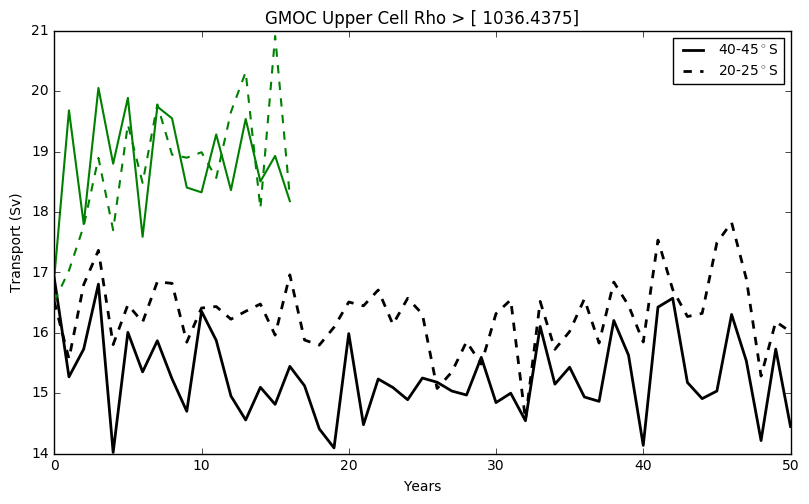

In [13]:

#plot time series of SO upper cell
T=np.arange(17)
print T.shape

# do lower cell average between lats 40-45S
j1=np.argwhere(yt_ocean<-45)
j2=np.argwhere(yt_ocean<-40)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(potrho<1036.5)
z1=z1[-1]

uc_cntrl40_psj = cntrl_gmoc[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_gmoc[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25S
j1=np.argwhere(yt_ocean<-25)
j2=np.argwhere(yt_ocean<-20)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_gmoc[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_gmoc[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert40_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='-',color='k',label='40-45$^\circ$S',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle='--',color='k',label='20-25$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='GMOC Upper Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)


(1080, 1440)
[-2 -1  0  1]


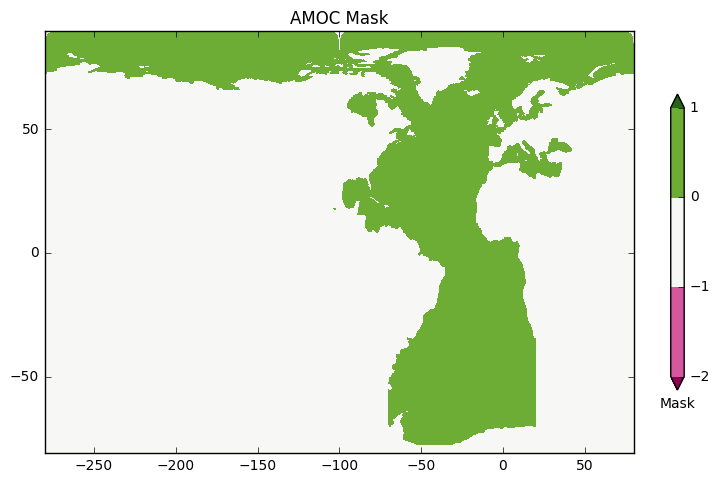

In [14]:
#calculate the AMOC mask
#-1 is Atl and Arctic, all other ocean is -2, land is 0
#reset to 1 and 0
msk_file='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/basin_mask.nc'
nc = Dataset(msk_file, mode='r') # file handle, open in read only mode
msk= nc.variables['kmt'][:]
nc.close() # close the file
print msk.shape
msk[np.where(msk<-1)]=0
msk[np.where(msk==-1)]=1

clev = np.arange(-2,2,1)
print clev

plt.subplot(211)
plt.contourf(geolon_t,geolat_t,msk,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Mask')
plt.title('AMOC Mask')

In [16]:
#calculate the AMOC  in rho space
Ocean_File = os.path.join(PertDir,'output*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans_rho.shape

ty=ff.ty_trans_rho*msk
print ty.shape
amoc=ty[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
print amoc.shape

of=os.path.join(PertDir,'pi_amoc_rho.npy')
a=np.save(of,amoc)



/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/output*/ocean.nc
(16, 80, 1080, 1440)
(16, 80, 1080, 1440)
(16, 80, 1080)


In [17]:
#do in zspace
Ocean_File = os.path.join(PertDir,'output*/ocean.nc')
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.ty_trans.shape
ty=ff.ty_trans*msk
print ty.shape
amoc=ty[:,:,:,:].sum('xt_ocean').cumsum('st_ocean').load()
print amoc.shape

of=os.path.join(PertDir,'pi_amoc_z.npy')
a=np.save(of,amoc)


/g/data1/v45/pas561/mom/archive/gfdl_nyf_PIAtlPos/output*/ocean.nc
(16, 50, 1080, 1440)
(16, 50, 1080, 1440)
(16, 50, 1080)


In [18]:
of=os.path.join(PertDir,'pi_amoc_z.npy')
pert_amoc_z=np.load(of)
print pert_amoc_z.shape

of=os.path.join(PertDir,'pi_amoc_rho.npy')
pert_amoc_rho=np.load(of)
print pert_amoc_rho.shape

of=os.path.join('/g/data1/v45/pas561/mom/archive/','cntrl_ape_amoc_rho.npy')
cntrl_amoc_rho=np.load(of)
print cntrl_amoc_rho.shape

of=os.path.join('/g/data1/v45/pas561/mom/archive/','cntrl_ape_amoc_z.npy')
cntrl_amoc_z=np.load(of)
print cntrl_amoc_z.shape

(16, 50, 1080)
(16, 80, 1080)
(51, 80, 1080)
(51, 50, 1080)


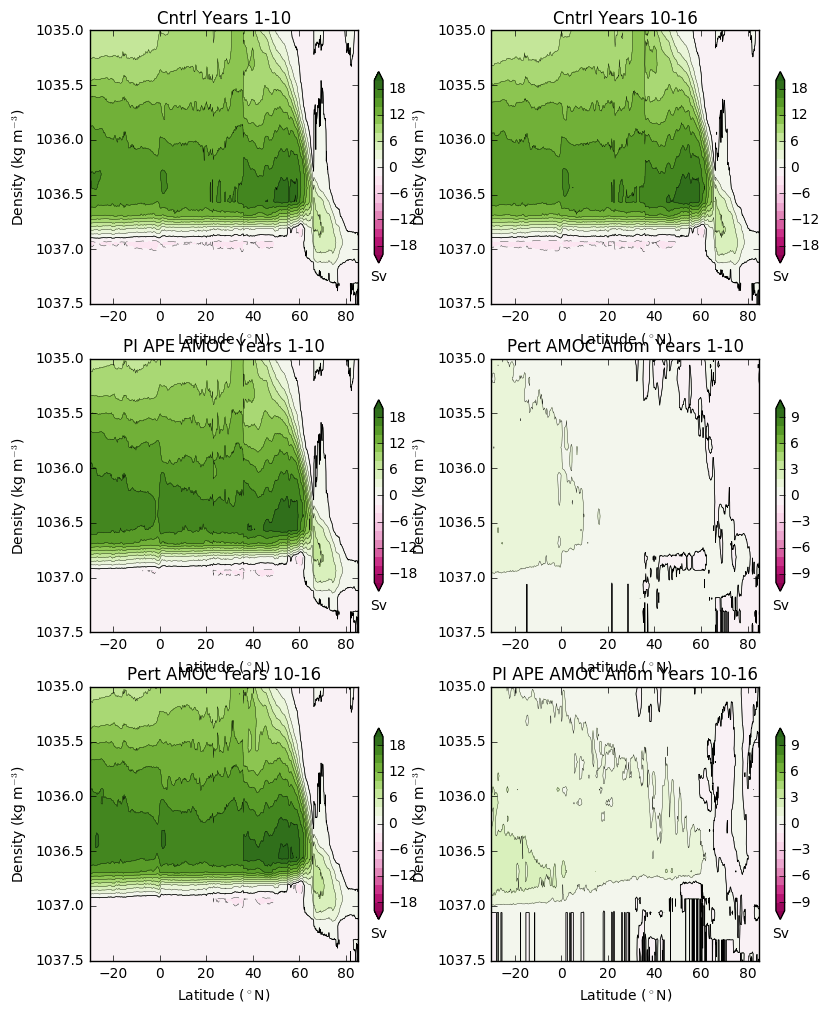

In [19]:
#Amoc in density space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=1
t2=10

plt.subplot(321)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=16

plt.subplot(322)
plt.contourf(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=1
t2=10

clev = np.arange(-20,22,2)

plt.subplot(323)
plt.contourf(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='PI APE AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(324)
plt.contourf(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Pert AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=16

clev = np.arange(-20,22,2)

plt.subplot(325)
plt.contourf(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Pert AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(326)
plt.contourf(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,potrho,np.mean(pert_amoc_rho[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_rho[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='PI APE AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

(15,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:35: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: converting an array with ndim > 0 to an

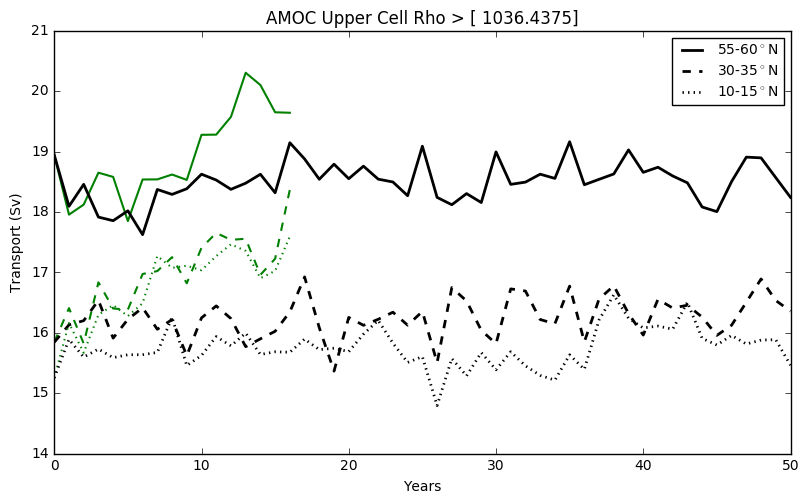

In [20]:
#plot time series of AMOC in rho space
#plot time series of SO upper cell
T=np.arange(15)
print T.shape


# do lower cell average between lats 55-60N
j1=np.argwhere(yt_ocean<55)
j2=np.argwhere(yt_ocean<60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(potrho<1036.5)
z1=z1[-1]

uc_cntrl50_psj = cntrl_amoc_rho[:,z1:,j1:j2]
uc_cntrl50_psj_bar = np.mean(uc_cntrl50_psj,2)
uc_cntrl50_psj_ts = np.max(uc_cntrl50_psj_bar,1)

uc_pert50_psj = pert_amoc_rho[:,z1:,j1:j2]
uc_pert50_psj_bar = np.mean(uc_pert50_psj,2)
uc_pert50_psj_ts = np.max(uc_pert50_psj_bar,1)
uc_pert50_psj_ts=np.insert(uc_pert50_psj_ts,0,uc_cntrl50_psj_ts[0])


# do lower cell average between lats 40-45N
j1=np.argwhere(yt_ocean<30)
j2=np.argwhere(yt_ocean<35)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(potrho<1036.5)
z1=z1[-1]

uc_cntrl40_psj = cntrl_amoc_rho[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_amoc_rho[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25N
j1=np.argwhere(yt_ocean<10)
j2=np.argwhere(yt_ocean<15)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_amoc_rho[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_amoc_rho[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert50_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl50_psj_ts,linestyle='-',color='k',label='55-60$^\circ$N',linewidth=2)
plt.plot(uc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='--',color='k',label='30-35$^\circ$N',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle=':',color='k',label='10-15$^\circ$N',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='AMOC Upper Cell Rho > ' +str(potrho[z1])
plt.title(tit)
plt.legend(fontsize=10)

(15,)
1030.6875
(15, 80, 1080)
(15, 1080)
1036.1875
(15, 80, 1080)
(15, 1080)


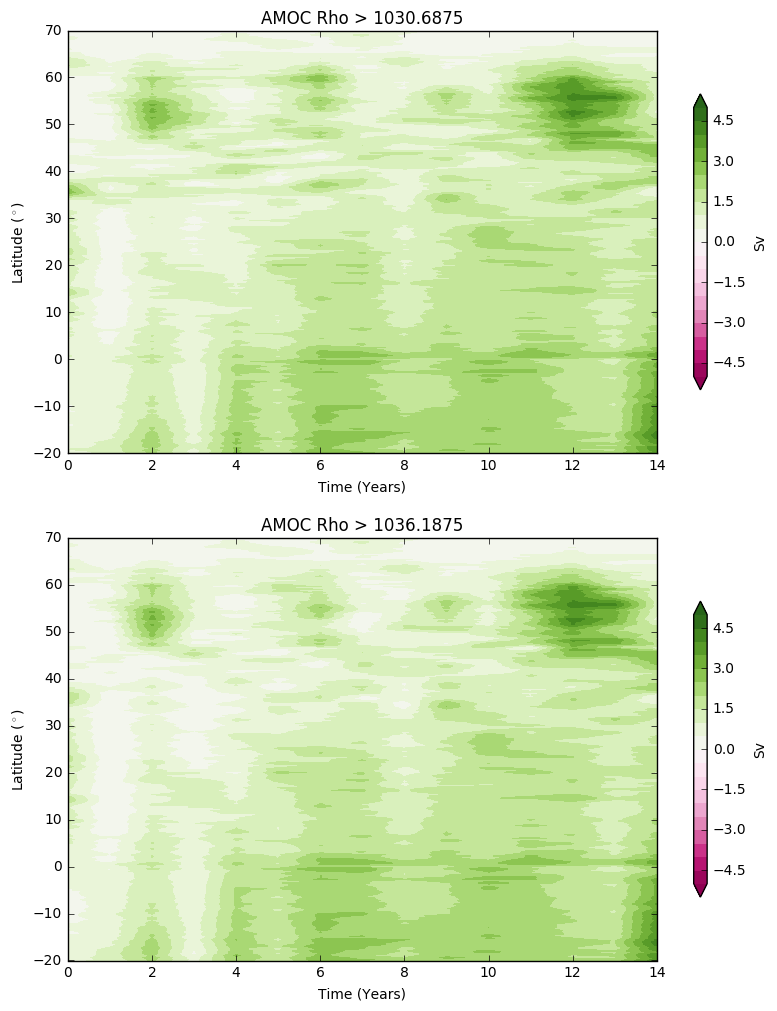

In [21]:
#AMOC Hovmoeller in rho space

t1=0
t2=15

time = np.arange(t1,t2,1)
print time.shape


print potrho[21]
st_min=21

amoc_rho_anom= pert_amoc_rho[t1:t2,:,:] - cntrl_amoc_rho[t1:t2,:,:]
print amoc_rho_anom.shape

amoc_rho_anom_max = np.max(amoc_rho_anom[:,st_min:,:],1)
print amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-5,5,21)
#print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
tit='AMOC Rho > ' +str(potrho[st_min])
plt.title(tit)

print potrho[65]
st_min=65

amoc_rho_anom= pert_amoc_rho[t1:t2,:,:] - cntrl_amoc_rho[t1:t2,:,:]
print amoc_rho_anom.shape

amoc_rho_anom_max = np.max(amoc_rho_anom[:,st_min:,:],1)
print amoc_rho_anom_max.shape

plt.subplot(212)
plt.contourf(time,yu_ocean,amoc_rho_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
tit='AMOC Rho > ' +str(potrho[st_min])
plt.title(tit)

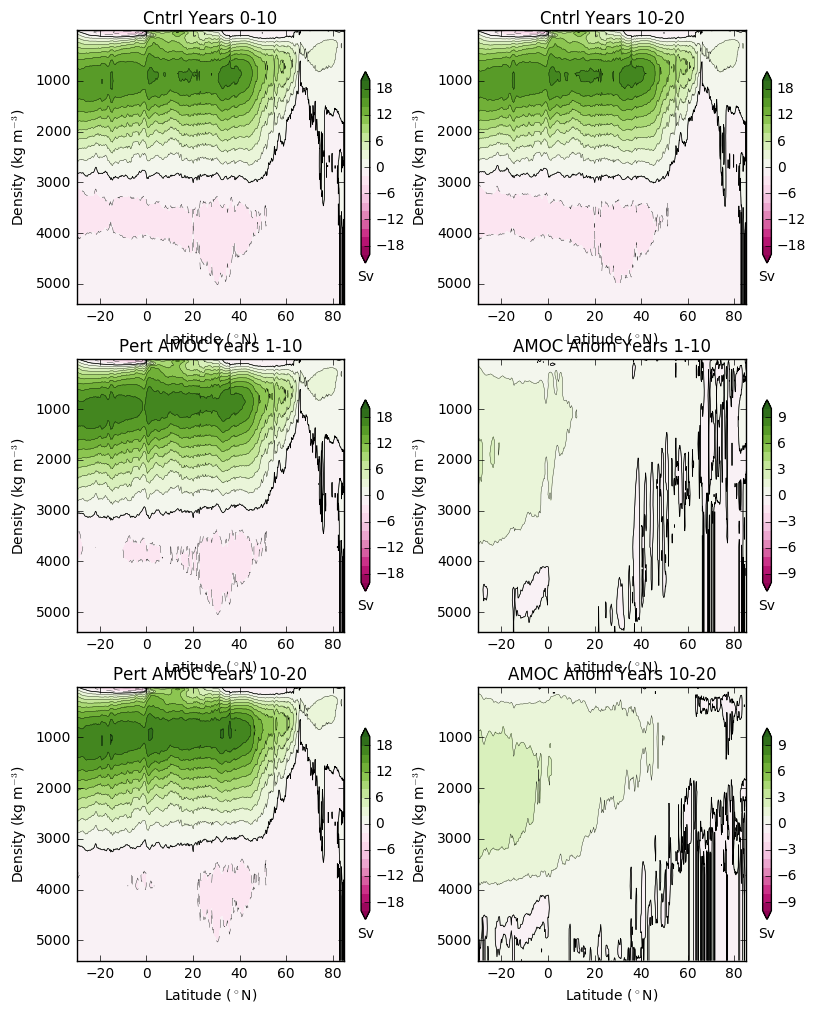

In [22]:
#Amoc in Z space
plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.arange(-20,22,2)

t1=0
t2=10

plt.subplot(321)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=20

plt.subplot(322)
plt.contourf(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Cntrl Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=1
t2=10

clev = np.arange(-20,22,2)

plt.subplot(323)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Pert AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(324)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

t1=10
t2=20

clev = np.arange(-20,22,2)

plt.subplot(325)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='Pert AMOC Years '+str(t1)+'-'+str(t2)
plt.title(tit)

clev = np.arange(-10,11,1)

plt.subplot(326)
plt.contourf(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('Sv')
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
plt.contour(yu_ocean,st_ocean,np.mean(pert_amoc_z[t1:t2,:,:],axis=0)-np.mean(cntrl_amoc_z[t1:t2,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
#plt.ylim((1037.5,1035))
plt.ylabel('Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-30,85])
tit='AMOC Anom Years '+str(t1)+'-'+str(t2)
plt.title(tit)

(15,)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: converting an array with ndim > 0 to an

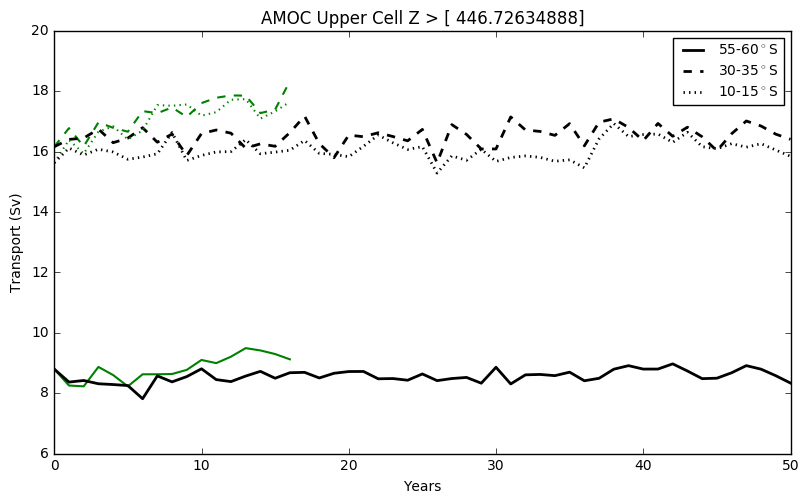

In [23]:
#plot time series of AMOC in rho space
#plot time series of SO upper cell
T=np.arange(15)
print T.shape


# do lower cell average between lats 55-60N
j1=np.argwhere(yt_ocean<55)
j2=np.argwhere(yt_ocean<60)
j1=j1[-1]
j2=j2[-1]

z1=np.argwhere(st_ocean<500)
z1=z1[-1]

uc_cntrl50_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl50_psj_bar = np.mean(uc_cntrl50_psj,2)
uc_cntrl50_psj_ts = np.max(uc_cntrl50_psj_bar,1)

uc_pert50_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert50_psj_bar = np.mean(uc_pert50_psj,2)
uc_pert50_psj_ts = np.max(uc_pert50_psj_bar,1)
uc_pert50_psj_ts=np.insert(uc_pert50_psj_ts,0,uc_cntrl50_psj_ts[0])


# do lower cell average between lats 40-45N
j1=np.argwhere(yt_ocean<30)
j2=np.argwhere(yt_ocean<35)
j1=j1[-1]
j2=j2[-1]

uc_cntrl40_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl40_psj_bar = np.mean(uc_cntrl40_psj,2)
uc_cntrl40_psj_ts = np.max(uc_cntrl40_psj_bar,1)

uc_pert40_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert40_psj_bar = np.mean(uc_pert40_psj,2)
uc_pert40_psj_ts = np.max(uc_pert40_psj_bar,1)
uc_pert40_psj_ts=np.insert(uc_pert40_psj_ts,0,uc_cntrl40_psj_ts[0])

# do lower cell average between lats 20-25N
j1=np.argwhere(yt_ocean<10)
j2=np.argwhere(yt_ocean<15)
j1=j1[-1]
j2=j2[-1]

uc_cntrl20_psj = cntrl_amoc_z[:,z1:,j1:j2]
uc_cntrl20_psj_bar = np.mean(uc_cntrl20_psj,2)
uc_cntrl20_psj_ts = np.max(uc_cntrl20_psj_bar,1)

uc_pert20_psj = pert_amoc_z[:,z1:,j1:j2]
uc_pert20_psj_bar = np.mean(uc_pert20_psj,2)
uc_pert20_psj_ts = np.max(uc_pert20_psj_bar,1)
uc_pert20_psj_ts=np.insert(uc_pert20_psj_ts,0,uc_cntrl20_psj_ts[0])


plt.subplot(211)
plt.plot(uc_pert50_psj_ts,linestyle='-',color='g',linewidth=1.5)
plt.plot(uc_cntrl50_psj_ts,linestyle='-',color='k',label='55-60$^\circ$S',linewidth=2)
plt.plot(uc_pert40_psj_ts,linestyle='--',color='g',linewidth=1.5)
plt.plot(uc_cntrl40_psj_ts,linestyle='--',color='k',label='30-35$^\circ$S',linewidth=2)
plt.plot(uc_pert20_psj_ts,linestyle=':',color='g',linewidth=1.5)
plt.plot(uc_cntrl20_psj_ts,linestyle=':',color='k',label='10-15$^\circ$S',linewidth=2)
#plt.ylim((1037.5,1035))
plt.ylabel('Transport (Sv)')
plt.xlabel('Years')
#plt.xlim([-75,85])
tit='AMOC Upper Cell Z > ' +str(st_ocean[z1])
plt.title(tit)
plt.legend(fontsize=10)

(15,)
[22]
(15, 80, 1080)
(15, 1080)


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


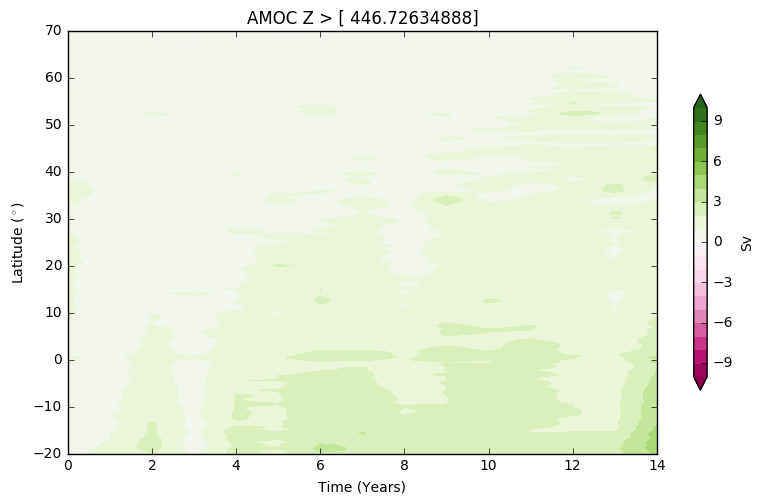

In [24]:
#AMOC Hovmoeller in Z space

t1=0
t2=15

time = np.arange(t1,t2,1)
print time.shape

st_min=np.argwhere(st_ocean<500)
st_min=st_min[-1]
print st_min

amoc_z_anom= pert_amoc_z[t1:t2,:,:] - cntrl_amoc_z[t1:t2,:,:]
print amoc_rho_anom.shape

amoc_z_anom_max = np.max(amoc_z_anom[:,st_min:,:],1)
print amoc_rho_anom_max.shape

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(-10,10,21)
#print clev

plt.subplot(211)
plt.contourf(time,yu_ocean,amoc_z_anom_max.T,cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Sv')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_amoc_rho[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Years)')
plt.ylim([-20,70])
tit='AMOC Z > ' +str(st_ocean[st_min])
plt.title(tit)

In [25]:
#north atl mld
Ocean_File = os.path.join('/g/data1/v45/APE-MOM/gfdl_nyf_1080_cp','output5*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
cntrl_mld=ff.mld.load()
print cntrl_mld.shape


(51, 1080, 1440)


In [26]:

Ocean_File = os.path.join(PertDir,'output*/ocean.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
pert_mld=ff.mld.load()
print pert_mld.shape

(16, 1080, 1440)


mld bounds lon1 lon2 lat1 lat2 [-99.875] [ 50.125] [ 30.13168517] 89.947282327


/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/pandas/indexes/base.py:1428: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return promote(getitem(key))
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/xarray/core/indexing.py:478: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._ensure_ndarray(self.array[key])
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/site-packages/numpy/ma/core.py:3158: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  dout = self.data[indx]
/g/data1/v45/pas561/anaconda/envs/oceanpy27/lib/python2.7/

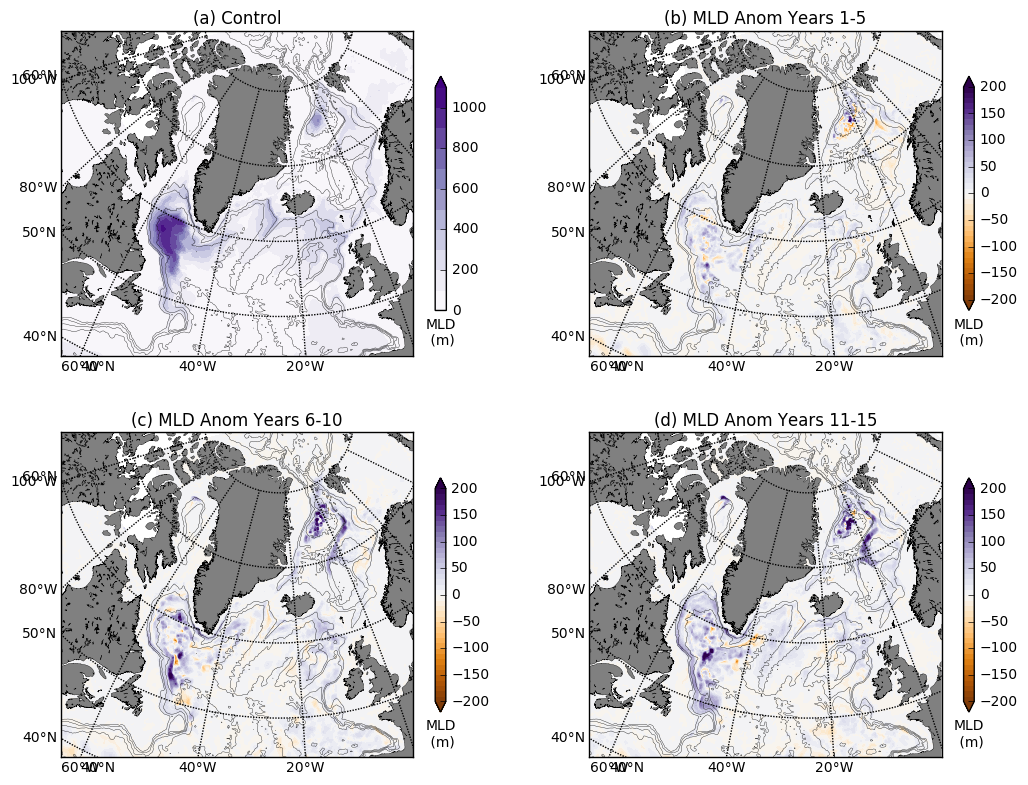

In [27]:
#plot mld
ii1=np.argwhere(xt_ocean>-100)# and lat<-45)
ii2=np.argwhere(xt_ocean>50)# and lat<-45)
jj1=np.argwhere(yt_ocean>30)# and lat<-45)
jj2=np.argwhere(yt_ocean>80)# and lat<-45)
ii1=ii1[0]
ii2=ii2[0]
jj1=jj1[0]
jj2=1079
#jj2=jj2[0]

print "mld bounds lon1 lon2 lat1 lat2", xt_ocean[ii1], xt_ocean[ii2], yt_ocean[jj1], yt_ocean[jj2]

plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

t1=0
t2=10
plt.subplot(221)#,axisbg='gray')
clev = np.arange(0,1200,100)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(cntrl_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0), cmap=plt.cm.Purples, levels=clev, extend='max') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
plt.title('(a) Control')
#plt.show()

clev = np.arange(-200,210,10)
#clev2 = np.arange(-200,200,10)

t1=0
t2=5
plt.subplot(222)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pert_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0)-np.mean(cntrl_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0),cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(b) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)
#plt.show()

t1=5
t2=10
plt.subplot(223)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pert_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0)-np.mean(cntrl_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0), cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(c) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)

t1=10
t2=15
plt.subplot(224)
map = Basemap(llcrnrlon=-63,llcrnrlat=38,urcrnrlon=59,urcrnrlat=72,resolution='i',projection='cass',lon_0=-25,lat_0=66)
X, Y = map(geolon_t[jj1:jj2,ii1:ii2],geolat_t[jj1:jj2,ii1:ii2]) 
map.contourf(X,Y,np.mean(pert_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0)-np.mean(cntrl_mld[t1:t2,jj1:jj2,ii1:ii2],axis=0), cmap=plt.cm.PuOr, levels=clev, extend='both') #CMRmap_r, gist_stern_r
cb = plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_xlabel('MLD\n (m)')
clev3 = np.arange(0,5000,1000)
map.contour(X,Y,ht[jj1:jj2,ii1:ii2],levels=clev3,colors='k',linewidths=0.25)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,10.),labels=[True,False,False,True])
map.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
tit='(d) MLD Anom Years ' +str(t1+1) +'-' +str(t2)
plt.title(tit)

plt.show()





In [24]:
print np.max(fh[540:1080,:])
print np.min(fh[540:1080,:])

3.59161e-06
4.91751e-09


In [32]:
#Hov of Sea Ice Conc. in Southern Ocean
print xt_ocean[1040]
print xt_ocean[878]

Ocean_File = os.path.join(CntrlDir,'output5*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
nyf_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print nyf_cn.shape

Ocean_File = os.path.join(PertDir,'output*/ice_month.nc')
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.CN.shape
pert_cn=ff.CN[:,:,:,878:1040].sum('ct').mean('xt').load()
print pert_cn.shape


-19.875
-60.375
(240, 5, 1080, 1440)
(240, 1080)
(192, 5, 1080, 1440)
(192, 1080)


(240, 1080)
(192, 1080)
(204, 1080)
(204,)
-19.875
-60.375
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


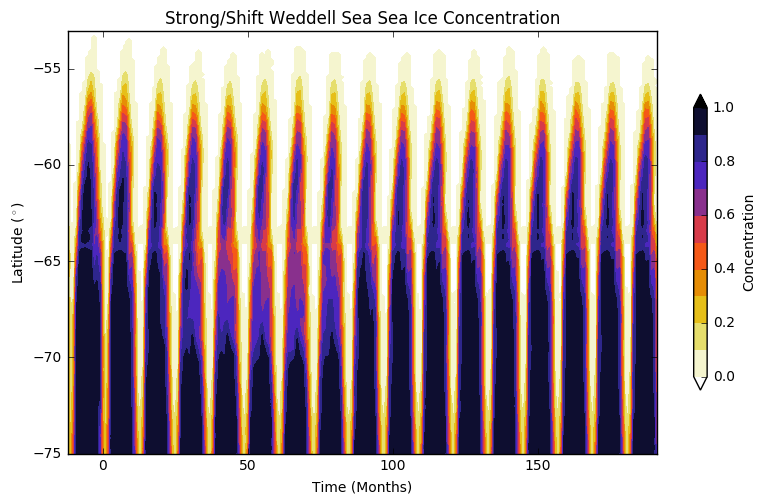

In [34]:
print nyf_cn.shape
print pert_cn.shape
cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
print cn.shape

time = np.arange(-12,192,1)
#print time
print time.shape

print xt_ocean[1040]
print xt_ocean[878]

plt.figure(figsize(9.5,12))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

clev = np.linspace(0,1.0,11)
print clev

plt.subplot(211)
plt.contourf(time,yt_ocean,cn.T,cmap=plt.cm.CMRmap_r,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical',shrink = 0.7)
cb.ax.set_ylabel('Concentration')
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=clev,colors='k',linewidths=0.25)
#plt.contour(yu_ocean,potrho,np.mean(cntrl_gmoc[0:4,:,:],axis=0),levels=[0.0,],colors='k',linewidths=0.5)
#plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_formatter(x_formatter)
plt.ylim((-75,-53))
#plt.ylim((1037.5,1035))
plt.ylabel('Latitude ($^\circ$)')
plt.xlabel('Time (Months)')
#plt.xlim([-75,85])
plt.title('Strong/Shift Weddell Sea Sea Ice Concentration')